# Vector quantization
- Instead of storing the vector, we store sub-vector i.e. the centroid of the vector (after computing k-means on them)
- Since many points would be reduced to centroids, we might lose precision. Hence original vectors are stored on disk, and after search, we rescore with the original vectors to improve precision. Obviously if centroids were calcualted incorrectly, the whole search is incorrect, however enough testing needs to be done to ensure precision is balanced with performance
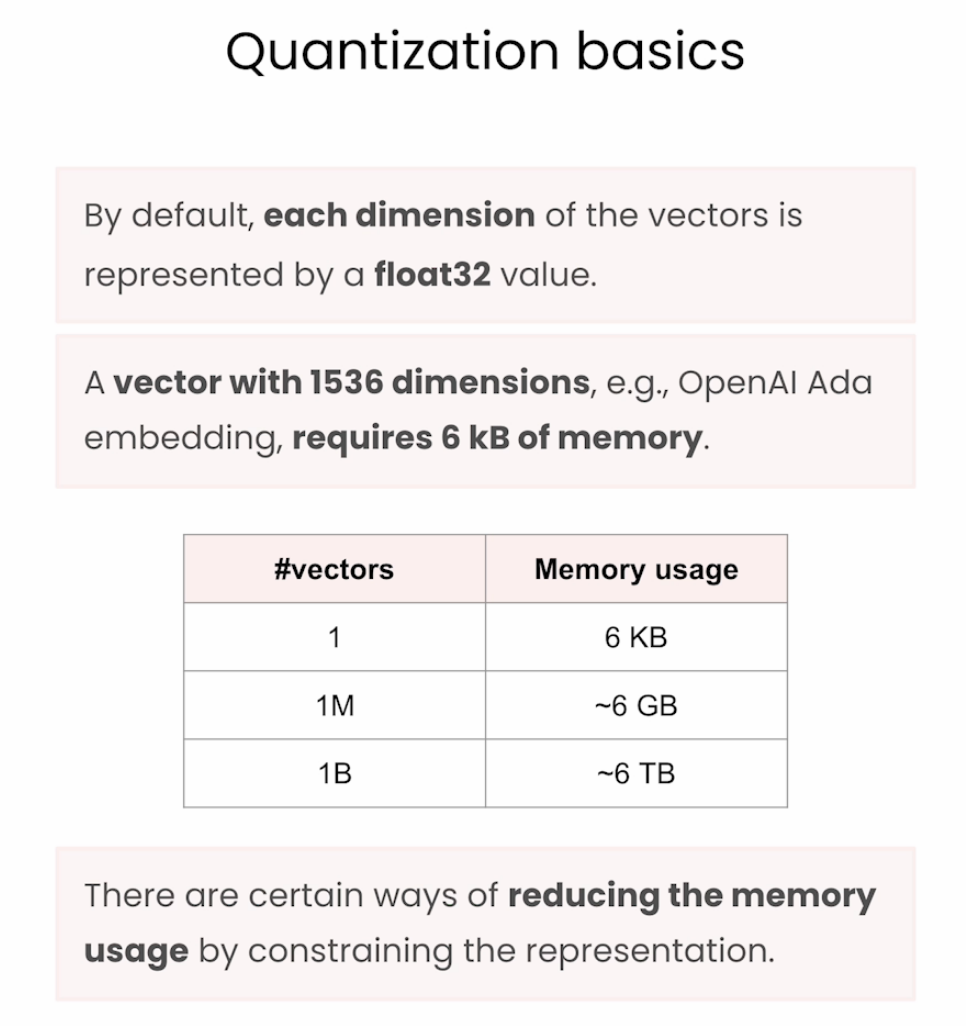
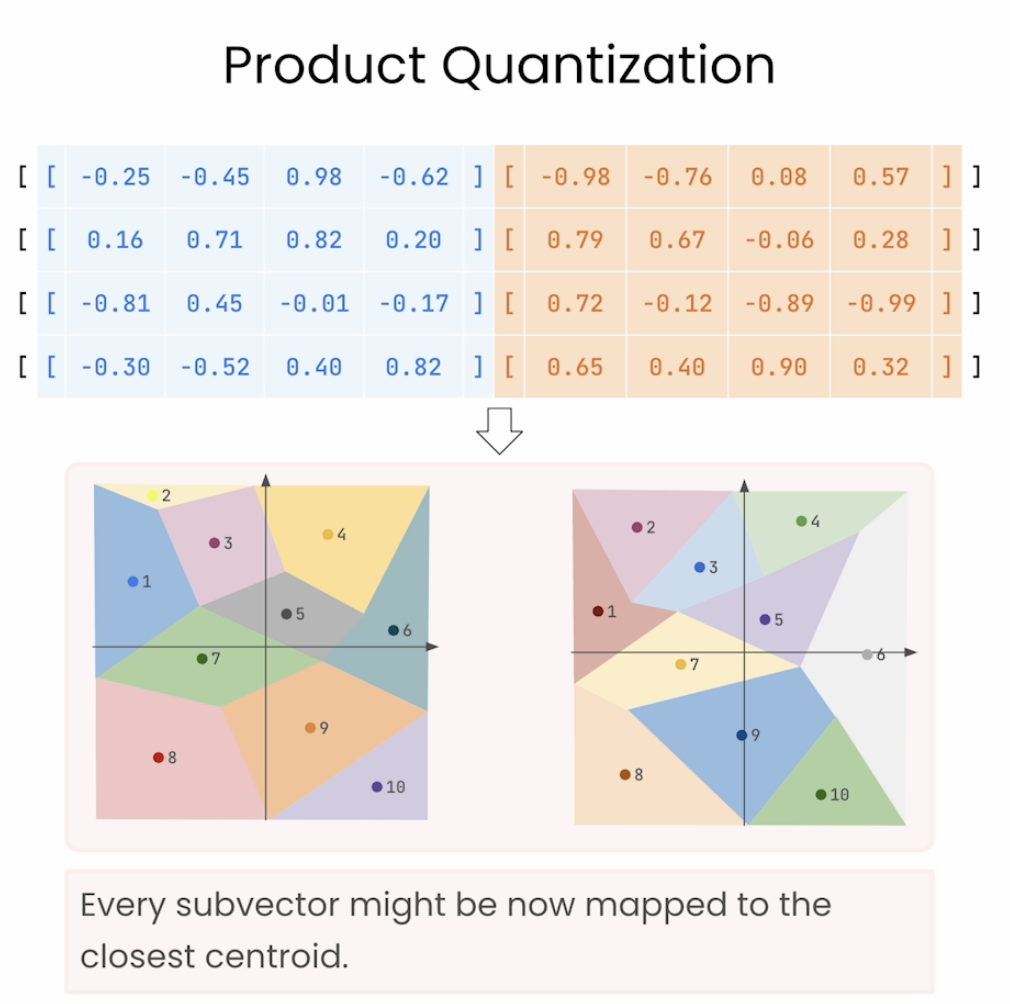
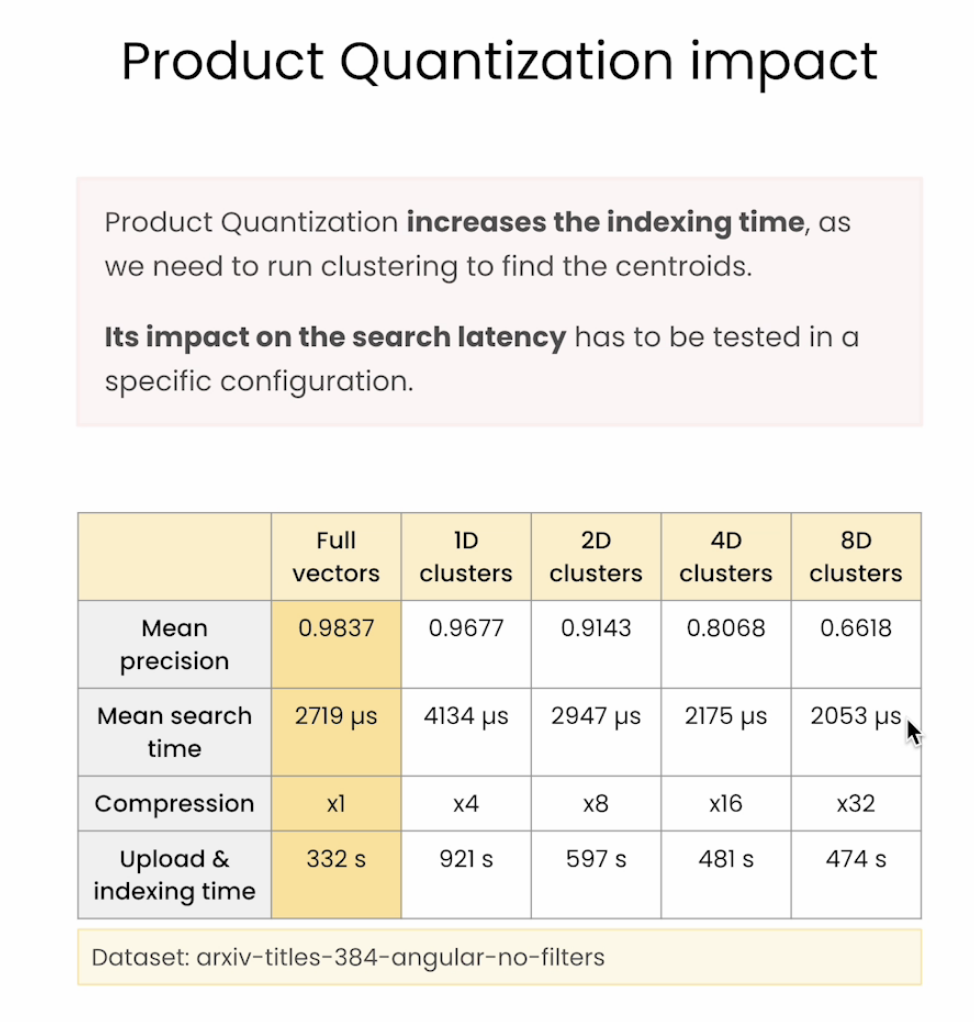
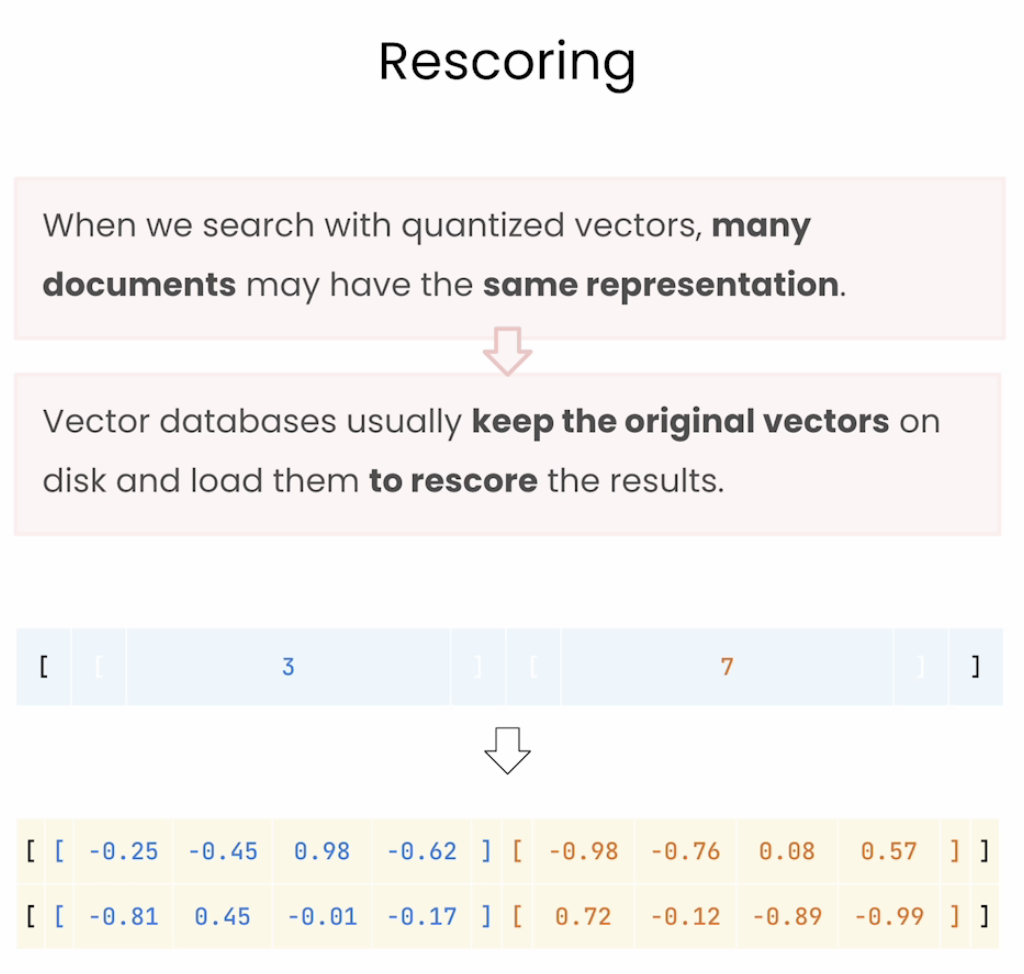

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from qdrant_client import QdrantClient, models

client = QdrantClient("http://localhost:6333", timeout=600)
collection = client.get_collection("wands-products")
collection

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=8960, points_count=5000, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors={'product_description': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'product_name': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=64, ef_construct=200, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segmen

# Test Queries

In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

/home/ubuntu/git-projects/personal/github.com/elasticsearch_opensearch/.venv/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/home/ubuntu/git-projects/personal/github.com/elasticsearch_opensearch/.venv/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
import pandas as pd

queries_df = pd.read_csv(
    "https://github.com/wayfair/WANDS/raw/refs/heads/main/dataset/query.csv", 
    sep="\t", 
    index_col="query_id",
)
queries_df["query_embedding"] = model.encode(
    queries_df["query"].tolist()
).tolist()
queries_df.sample(n=5)

,query,query_class,query_embedding
query_id,,,
323,hub leaning full length mirror,Wall & Accent Mirrors,"[0.06984298676252365, 0.017407862469553947, 0...."
407,huge bookcase,Bookcases,"[0.06058147922158241, 0.06107000261545181, -0...."
134,black hanging bookshelf,Bookcases,"[-0.021287117153406143, 0.051110804080963135, ..."
138,glass doors for bath,Shower & Tub Doors,"[0.036376141011714935, -0.013703051954507828, ..."
91,industrial pipe dining table,Dining Tables,"[0.01771600730717182, 0.028449488803744316, -0..."


In [4]:
from collections import defaultdict
from ranx import Qrels

knn_qrels_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        with_vectors=False,
        with_payload=False,
        limit=50,
        search_params=models.SearchParams(
            exact=True,  # enable exact search
        ),
    )
    
    for point in results:
        document_id = f"doc_{point.id}"
        # The conversion to integer is required because ranx expects integers
        knn_qrels_dict[query_id][document_id] = int(point.score * 100)

qrels = Qrels(knn_qrels_dict)
qrels

DictType[unicode_type,DictType[[unichr x 8],int64]<iv=None>]<iv=None>({query_0: {doc_4410: 75, doc_4034: 74, doc_251: 72, doc_2187: 72, doc_975: 69, doc_1616: 65, doc_4444: 65, doc_746: 64, doc_209: 64, doc_2638: 64, doc_1372: 63, doc_308: 63, doc_1148: 63, doc_1059: 63, doc_603: 62, doc_1742: 61, doc_4938: 61, doc_4330: 60, doc_1259: 60, doc_1864: 60, doc_4329: 59, doc_1373: 59, doc_1454: 59, doc_3604: 59, doc_2813: 58, doc_3880: 58, doc_4046: 58, doc_187: 58, doc_4709: 58, doc_206: 58, doc_489: 57, doc_4367: 57, doc_445: 57, doc_2245: 57, doc_4044: 57, doc_2584: 57, doc_1149: 57, doc_2321: 57, doc_703: 57, doc_1771: 56, doc_4013: 56, doc_585: 56, doc_2565: 56, doc_2729: 56, doc_701: 56, doc_1681: 56, doc_4050: 56, doc_1786: 56, doc_580: 55, doc_702: 55}, query_1: {doc_608: 81, doc_3408: 76, doc_607: 76, doc_295: 75, doc_3510: 74, doc_294: 74, doc_3557: 74, doc_1308: 72, doc_4778: 72, doc_296: 72, doc_290: 71, doc_1396: 71, doc_4312: 71, doc_3121: 71, doc_601: 70, doc_1307: 70, doc_36

# Product Quantization (PQ)

In [5]:
client.update_collection(
    "wands-products",
    quantization_config=models.ProductQuantization(
        product=models.ProductQuantizationConfig(
            compression=models.CompressionRatio.X64,
            always_ram=True,
        )    
    ),
)

True

In [6]:
import time

time.sleep(1.0)
collection = client.get_collection("wands-products")
while collection.status != models.CollectionStatus.GREEN:
    time.sleep(1.0)
    collection = client.get_collection("wands-products")
    
collection

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=8960, points_count=5000, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors={'product_description': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'product_name': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=64, ef_construct=200, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segmen

In [7]:
import numpy as np

response_times = []
pq_run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"

    # Measure the initial time
    start_time = time.monotonic()
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                rescore=False # Disable re-scoring using the original vectors
            )
        ),
        with_vectors=False,
        with_payload=False,
        limit=50,
    )

    # Store the response time in the list
    response_times.append(time.monotonic() - start_time)
    
    for point in results:
        document_id = f"doc_{point.id}"
        pq_run_dict[query_id][document_id] = point.score
    
np.mean(response_times)

0.0042838681125431325

In [8]:
from ranx import Run, evaluate

product_name_pq_run = Run(
    pq_run_dict, 
    name="product_name_pq"
)
evaluate(
    qrels=qrels, 
    run=product_name_pq_run, 
    metrics=["precision@25"]
)

1.0

In [9]:
response_times = []
pq_rescore_run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    start_time = time.monotonic()
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                rescore=True # Enable re-scoring using the original vectors
            )
        ),
        with_vectors=False,
        with_payload=False,
        limit=50,
    )
    
    response_times.append(time.monotonic() - start_time)
    
    for point in results:
        document_id = f"doc_{point.id}"
        pq_rescore_run_dict[query_id][document_id] = point.score
    
np.mean(response_times)

0.004340696769213536

In [10]:
product_name_pq_rescore_run = Run(
    pq_rescore_run_dict,
    name="product_name_pq_rescore"
)
evaluate(
    qrels=qrels, 
    run=product_name_pq_rescore_run, 
    metrics=["precision@25"]
)

1.0

# Scalar Quantization (SQ)

In [11]:
client.update_collection(
    "wands-products",
    quantization_config=models.ScalarQuantization(
        scalar=models.ScalarQuantizationConfig(
            type=models.ScalarType.INT8,
            always_ram=True,
        )    
    ),
)

True

In [12]:
time.sleep(1.0)
collection = client.get_collection("wands-products")
while collection.status != models.CollectionStatus.GREEN:
    time.sleep(1.0)
    collection = client.get_collection("wands-products")
    
collection

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=8960, points_count=5000, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors={'product_description': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'product_name': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=64, ef_construct=200, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segmen

In [13]:
response_times = []
sq_run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    start_time = time.monotonic()
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                rescore=False # Disable re-scoring using the original vectors
            )
        ),
        with_vectors=False,
        with_payload=False,
        limit=50,
    )
    
    response_times.append(time.monotonic() - start_time)
    
    for point in results:
        document_id = f"doc_{point.id}"
        sq_run_dict[query_id][document_id] = point.score
    
np.mean(response_times)

0.004485051211910711

In [14]:
product_name_sq_run = Run(
    sq_run_dict, 
    name="product_name_sq"
)
evaluate(
    qrels=qrels, 
    run=product_name_sq_run, 
    metrics=["precision@25"]
)

1.0

In [15]:
response_times = []
sq_rescore_run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    start_time = time.monotonic()
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                rescore=True # Enable re-scoring using the original vectors
            )
        ),
        with_vectors=False,
        with_payload=False,
        limit=50,
    )
    
    response_times.append(time.monotonic() - start_time)
    
    for point in results:
        document_id = f"doc_{point.id}"
        sq_rescore_run_dict[query_id][document_id] = point.score
    
np.mean(response_times)

0.00448362918808319

In [16]:
product_name_sq_rescore_run = Run(
    sq_rescore_run_dict, 
    name="product_name_sq_rescore"
)
evaluate(
    qrels=qrels, 
    run=product_name_sq_rescore_run, 
    metrics=["precision@25"]
)

1.0

# Binary Quantization (BQ)

In [17]:
client.update_collection(
    "wands-products",
    quantization_config=models.BinaryQuantization(
        binary=models.BinaryQuantizationConfig(
            always_ram=True,
        )    
    ),
)

True

In [18]:
time.sleep(1.0)
collection = client.get_collection("wands-products")
while collection.status != models.CollectionStatus.GREEN:
    time.sleep(1.0)
    collection = client.get_collection("wands-products")
    
collection

CollectionInfo(status=<CollectionStatus.GREEN: 'green'>, optimizer_status=<OptimizersStatusOneOf.OK: 'ok'>, vectors_count=None, indexed_vectors_count=8960, points_count=5000, segments_count=2, config=CollectionConfig(params=CollectionParams(vectors={'product_description': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None), 'product_name': VectorParams(size=384, distance=<Distance.COSINE: 'Cosine'>, hnsw_config=None, quantization_config=None, on_disk=None, datatype=None, multivector_config=None)}, shard_number=1, sharding_method=None, replication_factor=1, write_consistency_factor=1, read_fan_out_factor=None, on_disk_payload=True, sparse_vectors=None), hnsw_config=HnswConfig(m=64, ef_construct=200, full_scan_threshold=10000, max_indexing_threads=0, on_disk=False, payload_m=None), optimizer_config=OptimizersConfig(deleted_threshold=0.2, vacuum_min_vector_number=1000, default_segmen

In [19]:
response_times = []
bq_run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    start_time = time.monotonic()
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                rescore=False # Disable re-scoring using the original vectors
            )
        ),
        with_vectors=False,
        with_payload=False,
        limit=50,
    )
    
    response_times.append(time.monotonic() - start_time)
    
    for point in results:
        document_id = f"doc_{point.id}"
        bq_run_dict[query_id][document_id] = point.score
    
np.mean(response_times)

0.004862477674517625

In [20]:
product_name_bq_run = Run(
    bq_run_dict, 
    name="product_name_bq"
)
evaluate(
    qrels=qrels, 
    run=product_name_bq_run, 
    metrics=["precision@25"]
)

1.0

In [21]:
response_times = []
bq_rescore_run_dict = defaultdict(dict)
for id, row in queries_df.iterrows():
    query_id = f"query_{id}"
    
    start_time = time.monotonic()
    
    results = client.search(
        collection_name="wands-products",
        query_vector=models.NamedVector(
            name="product_name", 
            vector=row["query_embedding"]
        ),
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                rescore=True # Enable re-scoring using the original vectors
            )
        ),
        with_vectors=False,
        with_payload=False,
        limit=50,
    )
    
    response_times.append(time.monotonic() - start_time)
    
    for point in results:
        document_id = f"doc_{point.id}"
        bq_rescore_run_dict[query_id][document_id] = point.score
    
np.mean(response_times)

0.004762128531971636

In [22]:
product_name_bq_rescore_run = Run(
    bq_rescore_run_dict, 
    name="product_name_bq_rescore"
)
evaluate(
    qrels=qrels, 
    run=product_name_bq_rescore_run, 
    metrics=["precision@25"]
)

1.0

In [23]:
from ranx import compare

compare(
    qrels=qrels,
    runs=[
        product_name_pq_run, 
        product_name_pq_rescore_run, 
        product_name_sq_run, 
        product_name_sq_rescore_run, 
        product_name_bq_run, 
        product_name_bq_rescore_run,
    ],
    metrics=["precision@25"],
)

#    Model                      P@25
---  -----------------------  ------
a    product_name_pq               1
b    product_name_pq_rescore       1
c    product_name_sq               1
d    product_name_sq_rescore       1
e    product_name_bq               1
f    product_name_bq_rescore       1